In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df_all=pd.read_csv('fifa_0315.csv')

In [3]:
df2=df_all[['Wage','Rich_Club','Overall','Real_Face']]
df2.Wage=np.log1p(df2.Wage)

<AxesSubplot:>

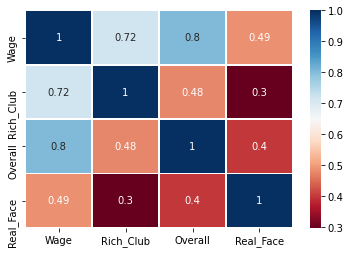

In [5]:
sns.heatmap(df2.corr(),linewidths=.8, annot=True, cmap='RdBu') 

# 다중공선성 파악하는 방법
[VIF = Variance inflation Factors 분산 팽창요인]

- 안전 : vif <5 
- 주의 : 5<vif<10 
- 위험: 10<vif

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['vif factor'] = [variance_inflation_factor(df2.values, i) 
                     for i in range(df2.shape[1])]
vif['features']=df2.columns
vif

,vif factor,features
0,11.343893,Wage
1,6.006552,Rich_Club
2,5.641655,Overall
3,1.455218,Real_Face


In [11]:
# 범주화 -> 원핫인코딩
df2.Real_Face = df2.Real_Face.astype('str')
df2.Rich_Club = df2.Rich_Club.astype('str')

In [12]:
df_o=pd.get_dummies(df2)

# 파라미터 구하기

In [13]:
X= df_o.drop(['Wage'],axis = 1)
y= df_o['Wage']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=156)
# 단순 회귀 분석 모형 생성 및 평가
lr = LinearRegression()
lr.fit(X_train, y_train)
pred= lr.predict(X_test)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,pred) # r_square = lr.score(X_test, y_test)도 같은 값

print('MSE: {0:.2f}, RMSE: {1:.2f}, r2 score: {2:.2f}'.format(mse, rmse,r2))

MSE: 0.19, RMSE: 0.44, r2 score: 0.82


In [14]:
params = {'alpha':[0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,12,15]}

lr = LinearRegression()
rd = Ridge()
ls = Lasso()

models = [rd,ls]
for model in models:
    grid = GridSearchCV(model, param_grid = params, cv=5, scoring = 'neg_mean_squared_error')
    grid.fit(X,y)
    rmse = np.sqrt(-1*grid.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,rmse, grid.best_params_))

Ridge 5 CV 시 최적 평균 RMSE 값: 0.5187467528581936, 최적 alpha:{'alpha': 0.001}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.5205515077724435, 최적 alpha:{'alpha': 0.001}


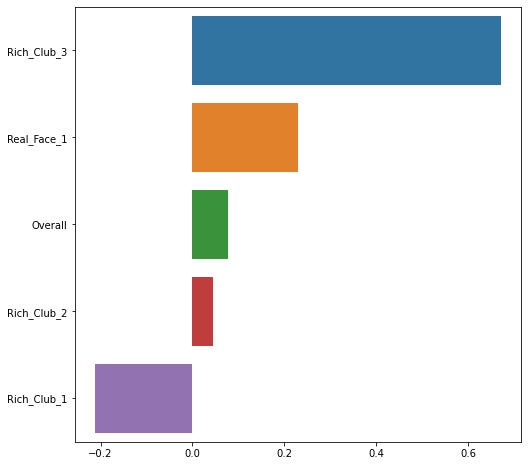

In [16]:
plt.figure(figsize=(8,8))
lr = LinearRegression()
lr.fit(X_train, y_train)
coef = pd.Series(lr.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)[:5]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

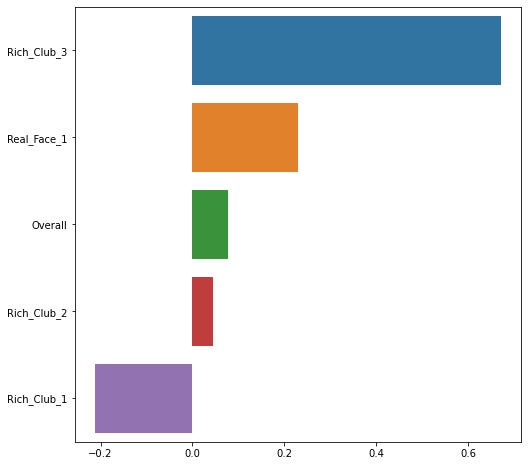

In [17]:
rd = Ridge(0.001)
rd.fit(X_train, y_train)
plt.figure(figsize=(8,8))
coef = pd.Series(rd.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)[:5]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

In [18]:
rd_pred= rd.predict(X_test)
mse = mean_squared_error(y_test,rd_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,rd_pred) # r_square = lr.score(X_test, y_test)도 같은 값

print('MSE: {0:.2f}, RMSE: {1:.2f}, r2 score: {2:.2f}'.format(mse, rmse,r2))

MSE: 0.19, RMSE: 0.44, r2 score: 0.82


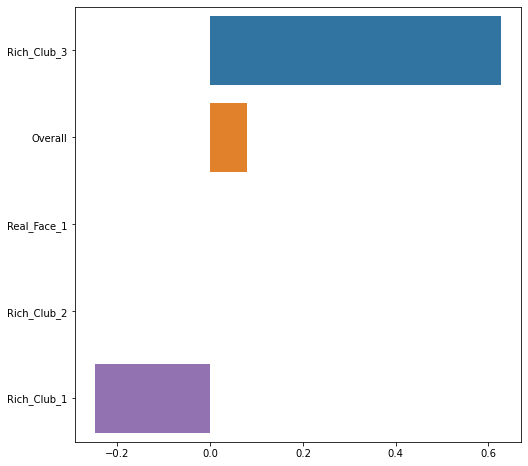

In [20]:
ls = Lasso(0.001)
ls.fit(X_train, y_train)
plt.figure(figsize=(8,8))
coef = pd.Series(ls.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)[:5]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

In [21]:
ls_pred= ls.predict(X_test)
mse = mean_squared_error(y_test,ls_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,ls_pred) # r_square = lr.score(X_test, y_test)도 같은 값

print('MSE: {0:.2f}, RMSE: {1:.2f}, r2 score: {2:.2f}'.format(mse, rmse,r2))

MSE: 0.19, RMSE: 0.44, r2 score: 0.82


In [23]:
rf_reg=RandomForestRegressor(n_estimators=1000,criterion='mse').fit(X_train,y_train)
rf_pred = rf_reg.predict(X_test)
mse = mean_squared_error(y_test,rf_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,rf_pred) # r_square = lr.score(X_test, y_test)도 같은 값

print('MSE: {0:.2f}, RMSE: {1:.2f}, r2 score: {2:.2f}'.format(mse, rmse,r2))


MSE: 0.12, RMSE: 0.35, r2 score: 0.88


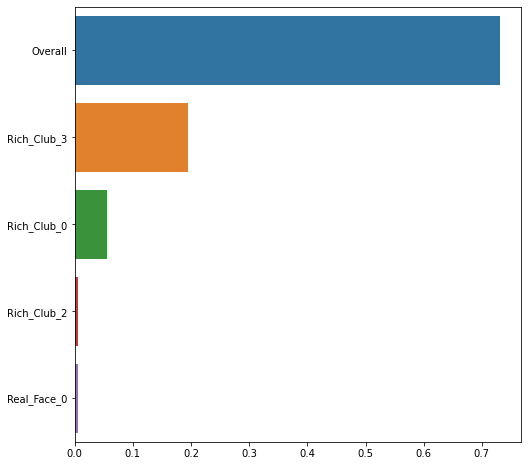

In [24]:
plt.figure(figsize=(8,8))
coef = pd.Series(data=rf_reg.feature_importances_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)[:5]
sns.barplot(x=coef_sort.values, y = coef_sort.index)

In [25]:
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                              np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [26]:
params = {'n_estimators':[800,1000, 1200]}

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)

In [27]:
# best estimator 사용
best_xgb = get_best_params(xgb_reg, params)
best_lgbm = get_best_params(lgbm_reg, params)
models = [best_xgb,best_lgbm]
for model in models:
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test,pred)
    print(model.__class__.__name__, 'MSE: {0:.2f},RMSE: {1:.2f}, r2 score: {2:.2f} '.format(mse, rmse,r2))

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.3473, 최적 alpha:{'n_estimators': 800}
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.3461, 최적 alpha:{'n_estimators': 1200}
XGBRegressor MSE: 0.12,RMSE: 0.34, r2 score: 0.88 
LGBMRegressor MSE: 0.12,RMSE: 0.35, r2 score: 0.88 


In [28]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X.columns  )
    ftr_top5 = ftr_importances.sort_values(ascending=False)[:5]
    return ftr_top5
def visualize_ftr_importances(models):
    plt.figure(figsize=(8,8))
    ftr_top5 = get_top_features(model)
    sns.barplot(x=ftr_top5.values, y=ftr_top5.index)

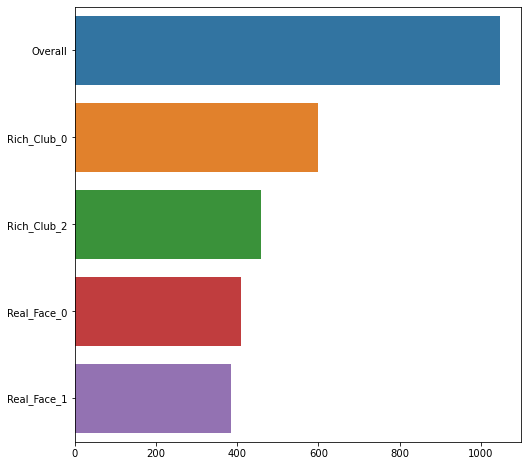

In [29]:
visualize_ftr_importances(best_xgb)

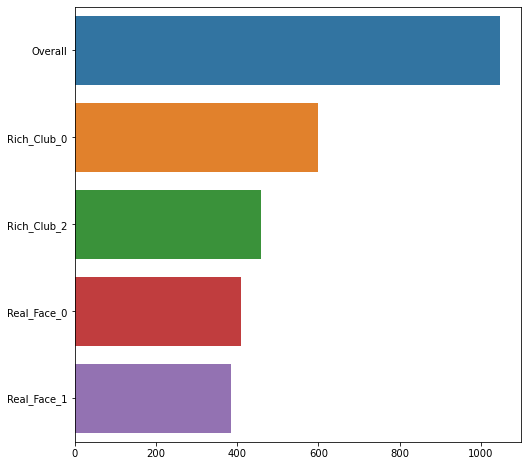

In [30]:
visualize_ftr_importances(best_lgbm)